# Language modeling


Будем рассматривать языковые модели на примере задачи генерации названий динозавров.

Обучим две различные символьные языковые модели:
* вероятностная модель на символьных биграммах
* ***RNN***-модель.



## Bigram probabilistic model


$$ P(W ) = P(w_{1} , . . . , w_{n} ) ≈ \prod_{i}	 P(w_{i} |w_{i−1} ) $$

Загрузим словарь названий динозавров

In [1]:
import os
from pathlib import Path
import numpy as np

nlp_data = Path(os.getcwd()) / "data"
print(nlp_data)

/Users/velo1/SynologyDrive/GIT_syno/Mac/Netology/NLP/data


In [2]:
# !wget https://raw.githubusercontent.com/artemovae/NLP-seminar-LM/master/dinos.txt

Следим за руками: действительно, названия динозавров

In [3]:
!cat data/dinos.txt | tail -6

Zuniceratops
Zunityrannus
Zuolong
Zuoyunlong
Zupaysaurus
Zuul

Добавим символы начала и конца динозавра.

In [4]:
names = ['<' + line.strip().lower() + '>' for line in open('data/dinos.txt').readlines()]
print(names[:10])
print(f'Number of names: {len(names)}, mean name length: {np.mean([len(name) for name in names]):.2f} chars')

['<aachenosaurus>', '<aardonyx>', '<abdallahsaurus>', '<abelisaurus>', '<abrictosaurus>', '<abrosaurus>', '<abydosaurus>', '<acanthopholis>', '<achelousaurus>', '<acheroraptor>']
Number of names: 1536, mean name length: 13.96 chars


**Важно** чтобы эти символы не встречались в самих именах

In [5]:
sum(char == '<' or char == '>' for line in open('data/dinos.txt').readlines() for char in line.strip().lower())

0

In [6]:
import nltk
from beholder import print_methods, call_methods

Вычислим частоту каждого символа в корпусе имен динозавров.

In [7]:
chars = [char for name in names for char in name]
freq = nltk.FreqDist(chars) # frequency distribution of characters
freq

FreqDist({'a': 2487, 's': 2285, 'u': 2123, 'o': 1710, 'r': 1704, '<': 1536, '>': 1536, 'n': 1081, 'i': 944, 'e': 913, ...})

In [8]:
_ = print_methods(freq)

26 methods for <class 'nltk.probability.FreqDist'>: 
 ['B', 'N', 'Nr', 'clear', 'copy', 'elements', 'freq', 'fromkeys', 'get', 'hapaxes', 'items', 'keys', 'max', 'most_common', 'pformat', 'plot', 'pop', 'popitem', 'pprint', 'r_Nr', 'setdefault', 'subtract', 'tabulate', 'total', 'update', 'values']


In [9]:
print(len(chars) == freq.N() == sum(freq.values())) # total number of characters
freq.N() 

True


21446

In [10]:
freq.tabulate(10, cumulative=False) # top 10 most frequent characters
freq.tabulate( cumulative=False) # all characters

   a    s    u    o    r    <    >    n    i    e 
2487 2285 2123 1710 1704 1536 1536 1081  944  913 
   a    s    u    o    r    <    >    n    i    e    t    l    p    h    c    g    d    m    y    b    k    v    x    z    j    w    f    q 
2487 2285 2123 1710 1704 1536 1536 1081  944  913  852  617  552  548  539  360  341  328  266  171  141  111   85   60   55   41   37   23 


In [11]:
freq.most_common()[:10] # return list of tuples (char, freq)

[('a', 2487),
 ('s', 2285),
 ('u', 2123),
 ('o', 1710),
 ('r', 1704),
 ('<', 1536),
 ('>', 1536),
 ('n', 1081),
 ('i', 944),
 ('e', 913)]

In [12]:
freq.keys() # return list of characters

dict_keys(['<', 'a', 'c', 'h', 'e', 'n', 'o', 's', 'u', 'r', '>', 'd', 'y', 'x', 'b', 'l', 'i', 't', 'p', 'v', 'm', 'g', 'f', 'j', 'k', 'w', 'z', 'q'])

Функция для вычисления вероятности появления каждого символа:

In [13]:
def unigram_prob(char):
    # freq[char] - number of occurences of char
    # len(chars) - total number of chars
    # freq[char] / len(chars) - probability of char
    return freq[char] / freq.N()

for _, tupl in zip(range(5),freq.most_common()):  # iterate over the first 5 most common characters
    letter = tupl[0]   # retrieve the letter from the tuple (letter, frequency)
    print(f'p({letter}) = {unigram_prob(letter):1.4f}')

p(a) = 0.1160
p(s) = 0.1065
p(u) = 0.0990
p(o) = 0.0797
p(r) = 0.0795


In [14]:
import plotly.express as px

fig = px.bar(x=list(freq.keys()), y=list(freq.values()), labels={'x':'chars', 'y':'freq'}, title='Unigram frequency distribution')
# sort x-axis by frequency
fig.update_xaxes(categoryorder='total descending')
fig.show()

Вычислим условную вероятность каждого символа в зависимости от того, какой символ стоял на предыдущей позиции.

In [15]:
bi_grams = list(nltk.bigrams(sequence=chars)) # bigrams (char, char)
cfreq = nltk.ConditionalFreqDist(cond_samples=bi_grams) # conditional frequency distribution of bigrams (char, char)
print(cfreq.keys()) 
cfreq['a'] # frequency distribution of bigrams starting with 'a'


dict_keys(['<', 'a', 'c', 'h', 'e', 'n', 'o', 's', 'u', 'r', '>', 'd', 'y', 'x', 'b', 'l', 'i', 't', 'p', 'v', 'm', 'g', 'f', 'j', 'k', 'w', 'z', 'q'])


FreqDist({'u': 791, 'n': 347, 't': 204, 's': 171, 'l': 138, '>': 138, 'r': 124, 'c': 100, 'p': 89, 'm': 68, ...})

In [16]:
from beholder import print_methods

_ = print_methods(cfreq['a'])

26 methods for <class 'nltk.probability.FreqDist'>: 
 ['B', 'N', 'Nr', 'clear', 'copy', 'elements', 'freq', 'fromkeys', 'get', 'hapaxes', 'items', 'keys', 'max', 'most_common', 'pformat', 'plot', 'pop', 'popitem', 'pprint', 'r_Nr', 'setdefault', 'subtract', 'tabulate', 'total', 'update', 'values']


In [17]:
print(sum(cfreq['a'].values()) )   # total number of bigrams starting with 'w'

print(cfreq['w']['a']) # - number of bigrams 'wa'
print(cfreq['s']['w']) # - number of bigrams 'sw'
print(cfreq['q']['u']) # - number of bigrams 'qu'
print(cfreq['w']['x']) # - number of bigrams 'wx'
print(cfreq['>']['<']) # - number of bigrams 'ww'

2487
17
0
12
0
1535


### The maximum conditional probability of a symbol

In [18]:
cfreq['q'].most_common(1)

[('u', 12)]

In [19]:
max_prob = 0
max_bigram = ""
freq_ = freq
del freq_['>']  # remove < and > from the list of characters
for char in freq.keys():    # iterate over all characters
        char2, cnt = cfreq[char].most_common()[0]  # most frequent bigram starting with given char and its count
        prob = cnt / freq_[char]    # probability of char2 given char
        if prob > max_prob:
            max_prob = prob
            max_bigram = (char, char2)

print(f'p({max_bigram[0]}|{max_bigram[1]}) = {max_prob:1.2%}')

p(q|u) = 52.17%


Character 'u' is the most likely to follow 'q' with probability 52.17% among all other possible combinations.  
But overall probability of 'q' is 23/21446 (0.1%) which is very low.

In [20]:
print(cfreq['q'].most_common(5))  # top 5 most frequent bigrams starting with 'q'
print(cfreq['q'].N() ) # total number of bigrams starting with 'q'
print(cfreq['q']['u']/cfreq['q'].N()) # probability of 'u' given 'q'

[('u', 12), ('i', 7), ('s', 1), ('w', 1), ('a', 1)]
23
0.5217391304347826


In [21]:
cfreq['q'].freq('u'), cfreq['q'].total() # probability of 'u' given 'q'

(0.5217391304347826, 23)

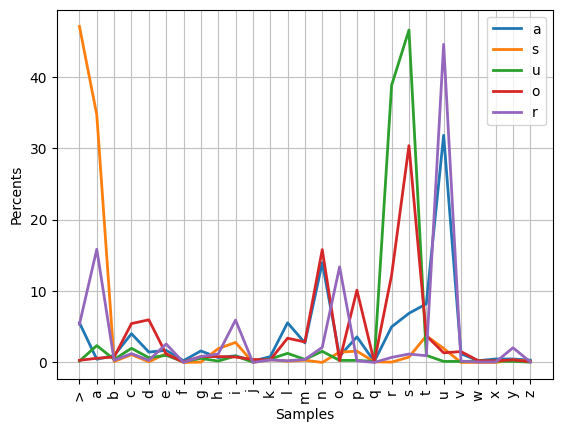

s[('>', 1075)]
a[('u', 791)]
r[('u', 759)]
u[('s', 988)]
q[('u', 12)]
>[('<', 1535)]


In [22]:
cfreq.plot(conditions=[keys[0] for keys in freq.most_common(5)], cumulative=False, percents=True)
# cfreq.plot(conditions=[char for char in set(chars)], cumulative=False)
# plot the conditional frequency distribution of the top 10 most frequent characters
# to find what character is most likely TO FOLLOW the given character, 
# you should choose a char in the legend and find the peak ((most frequent)) of appropriate color line. 
# X axis of this peak is the most likely character to follow the chosen character.
# 's'(orange peak) -> '>' (s>)
# 'a'(blue peak) -> 'u' (au)
# 'r'(violet peak) -> 'u' (ru)
for char in 'saruq>':
    print(f'{char}{cfreq[char].most_common(1)}')

Оценим условные вероятности с помощью MLE (Maximum Likelihood Estimation).

In [23]:
cprob = nltk.ConditionalProbDist(cfreq, nltk.MLEProbDist)   # conditional probability distribution of bigrams (char, char)
print(f'p(aa) = {cprob["a"].prob("a"):1.2%}')
print(f'p(ab) = {cprob["a"].prob("b"):1.2%}')
print(f'p(qu) = {cprob["q"].prob("u"):1.2%}')
print(f'p(s>) = {cprob["s"].prob(">"):1.2%}')
print(f'p(us) = {cprob["u"].prob("s"):1.2%}')
print(f'p(><) = {cprob[">"].prob("<"):1.2%}')

p(aa) = 0.44%
p(ab) = 0.97%
p(qu) = 52.17%
p(s>) = 47.05%
p(us) = 46.54%
p(><) = 100.00%


In [24]:
from collections import Counter

# Use Counter to count the occurrences of each bigram
bigram_counts = Counter(bi_grams)

del bigram_counts[('>', '<')] # remove tuple (('>', '<') from the list of characters

# Find the top-2 most common bigram
most_common_bigram, count = bigram_counts.most_common()[0] # most_common() returns a list of tuples (bigram, count)

print(f"The most common bigram is {most_common_bigram} with a count of {count}.")
for el in bigram_counts.most_common(5):
    print(el[0], el[1]) 


The most common bigram is ('s', '>') with a count of 1075.
('s', '>') 1075
('u', 's') 988
('u', 'r') 824
('s', 'a') 792
('a', 'u') 791


In [27]:
bigrams_freq_distr = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)[:30]
# bigrams_freq_distr = [{el[0]+el for el in bigrams_freq_distr]

In [63]:
# plot the distribution of bigram counts
fig = px.bar(x=list([el[0]+el[1] for el in bigram_counts.keys()]), y=list(bigram_counts.values()), labels={'x':'bigrams', 'y':'freq'}, title='Bigrams frequency distribution')
# sort x-axis by frequency
fig.update_xaxes(categoryorder='total descending')
# limit x-axis to top 30 most frequent bigrams
fig.update_xaxes(range=[0, 30])
fig.show()

In [29]:
# another approach to find the most frequent bigram
bi_grams_unique = set([el for el in nltk.bigrams(sequence=chars) if el[0] not in '<>']) 
print(f'Number of unique bigrams: {len(bi_grams_unique)}')

Number of unique bigrams: 436


### Упражнение 1.
a. Напишите функцию для генерации названия динозавра **фиксированной** длины. Используйте '<' в качестве символа начала последовательности.


In [31]:
def generate_dino_fixlength(text='<', length=50):
  '''Generate dinosaur name with fixed length'''
  text_ = text
  while len(text_) != length + 2 or text_[-1] != '>': # +2 because of '<' and '>'
    text_ = text
    while text_[-1] != '>' and len(text_) < length + 2: # +2 because of '<' and '>'
      # from cprob (dictionary of conditional probability distributions) take distribution for last char in text
      # and generate random char after last char in text
      text_ += cprob[text_[-1]].generate()
  return text_

In [32]:
for i in range(10):
  print(generate_dino_fixlength(text='<trump', length=13) )


<trumpycilorus>
<trumphtameros>
<trumphoprodon>
<trumpusaushys>
<trumpherusius>
<trumptrururus>
<trumpsanpurus>
<trumpptoiapto>
<trumpteyosaus>
<trumperoptrus>



b. Напишите функцию для генерации названия произвольной длины. 

In [33]:
def generate_dino_freelength(text='<', length=50, min_length=9):
  '''Generate dinosaur name with free length'''
  while text[-1] != '>' and len(text) < length + 2: # +2 because of '<' and '>'
    # from cprob (dictionary of conditional probability distributions) take distribution for last char in text
    # and generate random char after last char in text
    text += cprob[text[-1]].generate()
    if len(text) < min_length and text[-1] == '>':
      text = text[:-1]  # remove '>' if the text is too short
      
    # text += cprob[text[-1]].generate()  
  return text

In [34]:
cnt = 0
while cnt < 5:
  name = generate_dino_freelength(text='<trump')
  if len(name) <23:
    print(name)
    cnt += 1


<trumphus>
<trumpomos>
<trumpteliusaceinona>
<trumpenitrus>
<trumplosimurantecos>


## Реккурентные нейронные сети (RNN)

Исходная последовательность:

$x_{1:n} = x_1, x_2, \ldots, x_n$, $x_i \in \mathbb{R}^{d_{in}}$

Для каждого входного значения $x_{1:i}$ получаем на выходе $y_i$:

$y_i = RNN(x_{1:i})$, $y_i \in \mathbb{R}^{d_{out}}$

Для всей последовательности $x_{1:n}$:

$y_{1:n} = RNN^{*}(x_{1:n})$, $y_i \in \mathbb{R}^{d_{out}}$

$R$ - рекурсивная функция активации, зависящая от двух параметров: $x_i$ и $s_{i-1}$ (вектор предыдущего состояния)

$RNN^{*}(x_{1:n}, s_0) = y_{1:n}$

$y_i = O(s_i) = g(W^{out}[s_{i} ,x_i] +b)$; $[s_{i}, x_{i}]$ -- конкатенация

$s_i = R(s_{i-1}, x_i) = g(W^{hid}[s_{i-1} ,x_i] +b)$

$x_i \in \mathbb{R}^{d_{in}}$, $y_i \in \mathbb{R}^{ d_{out}}$, $s_i \in \mathbb{R}^{d_{hid}}$

$W^{hid} \in \mathbb{R}^{(d_{in}+d_{out}) \times d_{hid}}$, $W^{out} \in \mathbb{R}^{d_{hid} \times d_{out}}$

Построим языковую модель на основе RNN с помощью pytorch.

### RNN model for sequence generation

In [35]:
# !pip install torch

In [36]:
import numpy as np
import random
import torch    # main library
import torch.nn as nn   # neural networks
import torch.optim as optim  # optimizers
import pdb
from torch.utils.data import Dataset, DataLoader
import os
from datetime import datetime

%load_ext autoreload
%autoreload 2

torch.set_printoptions(linewidth=200)

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hidden_size = 50
device

device(type='cpu')

Подготовим данные

In [38]:
class DinosDataset(Dataset):
    '''Dataset of dinosaur names'''
    def __init__(self):
        '''Initialize dataset'''
        super().__init__()
        with open('data/dinos.txt') as f:
            content = f.read().lower()  # read file and convert to lowercase
            self.lines = content.splitlines()   # list of dinosaur names in lowercase
            content = content.replace('\n', '') # remove newlines, flatten the file to one line
            self.vocab = sorted(set(content)) + ['<', '>']  # list of unique characters + '<' and '>'
            self.vocab_size = len(self.vocab)   # number of unique characters + '<' and '>'
        self.ch_to_idx = {c:i for i, c in enumerate(self.vocab)} # dict of char to index
        self.idx_to_ch = {i:c for i, c in enumerate(self.vocab)} # dict of index to char
    
    def __getitem__(self, index)->tuple:
        '''To make dataset iterable
        By adding '<' to the beginning of the input and '>' to the end of the target, 
        you are essentially providing the model with the context of the previous character when
        it's predicting the next character. This allows the model to learn the patterns and relationships
        between characters in a sequential manner.

        Return tuple of input and target tensors
        Input tensor shape: (len(x_str), vocab_size) 
        Target tensor shape: (len(x_str),)
        '''

        line = self.lines[index]    # get dinos name by index
        x_str = '<' + line        # add '<' to the beginning of the name
        y_str = line + '>'      # add '>' to the end of the name

        # заготовки с нулями
        x = torch.zeros([len(x_str), self.vocab_size], dtype=torch.float) # shape: (len(x_str), vocab_size)
        y = torch.empty(len(x_str), dtype=torch.long)                  # shape: (len(x_str),)

        # заполняем заготовки for bigrams (x[i], y[i])
        for i, (x_ch, y_ch) in enumerate(zip(x_str, y_str)):
            x[i][self.ch_to_idx[x_ch]] = 1  # replace 0 with 1, analog of one-hot encoding
            y[i] = self.ch_to_idx[y_ch]     # fill in list with index of y_ch
        
        return x, y
    
    def __len__(self):
        '''Return length of dataset'''
        return len(self.lines)

In [39]:
# def collate_fn(batch):
#     # Assuming batch is a list of tuples (x, y)
#     x_batch, y_batch = zip(*batch)
    
#     # Pad sequences to the length of the longest sequence in the batch
#     x_padded = nn.utils.rnn.pad_sequence(x_batch, batch_first=True)
#     y_padded = nn.utils.rnn.pad_sequence(y_batch, batch_first=True)
    
#     return x_padded, y_padded


In [40]:
trn_ds = DinosDataset()     # init dataset
# trn_dl = DataLoader(trn_ds, batch_size=512, shuffle=True, collate_fn=collate_fn)   # init dataloader
trn_dl = DataLoader(trn_ds, shuffle=True)   # init dataloader

Опишем модель, функцию потерь и алгоритм оптимизации

In [41]:
class RNN(nn.Module):
    '''RNN model for sequence generation'''
    def __init__(self, input_size, hidden_size, output_size):
        '''Initialize model
        input_size - size of input vector
        hidden_size - size of hidden state
        output_size - size of output vector
        '''
        super().__init__()  # init parent class
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # input to hidden
        self.dropout = nn.Dropout(0.0)                  # dropout layer to prevent overfitting
        self.h2o = nn.Linear(hidden_size, output_size)  # hidden to output, output_size = vocab_size (number of unique chars)
    
    def forward(self, h_prev, x):
        '''Forward pass
        h_prev - previous hidden state
        x - input vector
        '''
        combined = torch.cat([h_prev, x], dim = 1) # concatenate input x and previous h (hidden state)
        # h = torch.tanh(self.dropout(self.i2h(combined)))    # calculate new hidden state h
        h = torch.tanh(self.i2h(combined))   # calculate new hidden state h
        y = self.h2o(h) # calculate output y
        return h, y

In [42]:
trn_ds.vocab_size

28

In [43]:
model = RNN(trn_ds.vocab_size, hidden_size, trn_ds.vocab_size).to(device)
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=1e-3)
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
model

RNN(
  (i2h): Linear(in_features=78, out_features=50, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (h2o): Linear(in_features=50, out_features=28, bias=True)
)

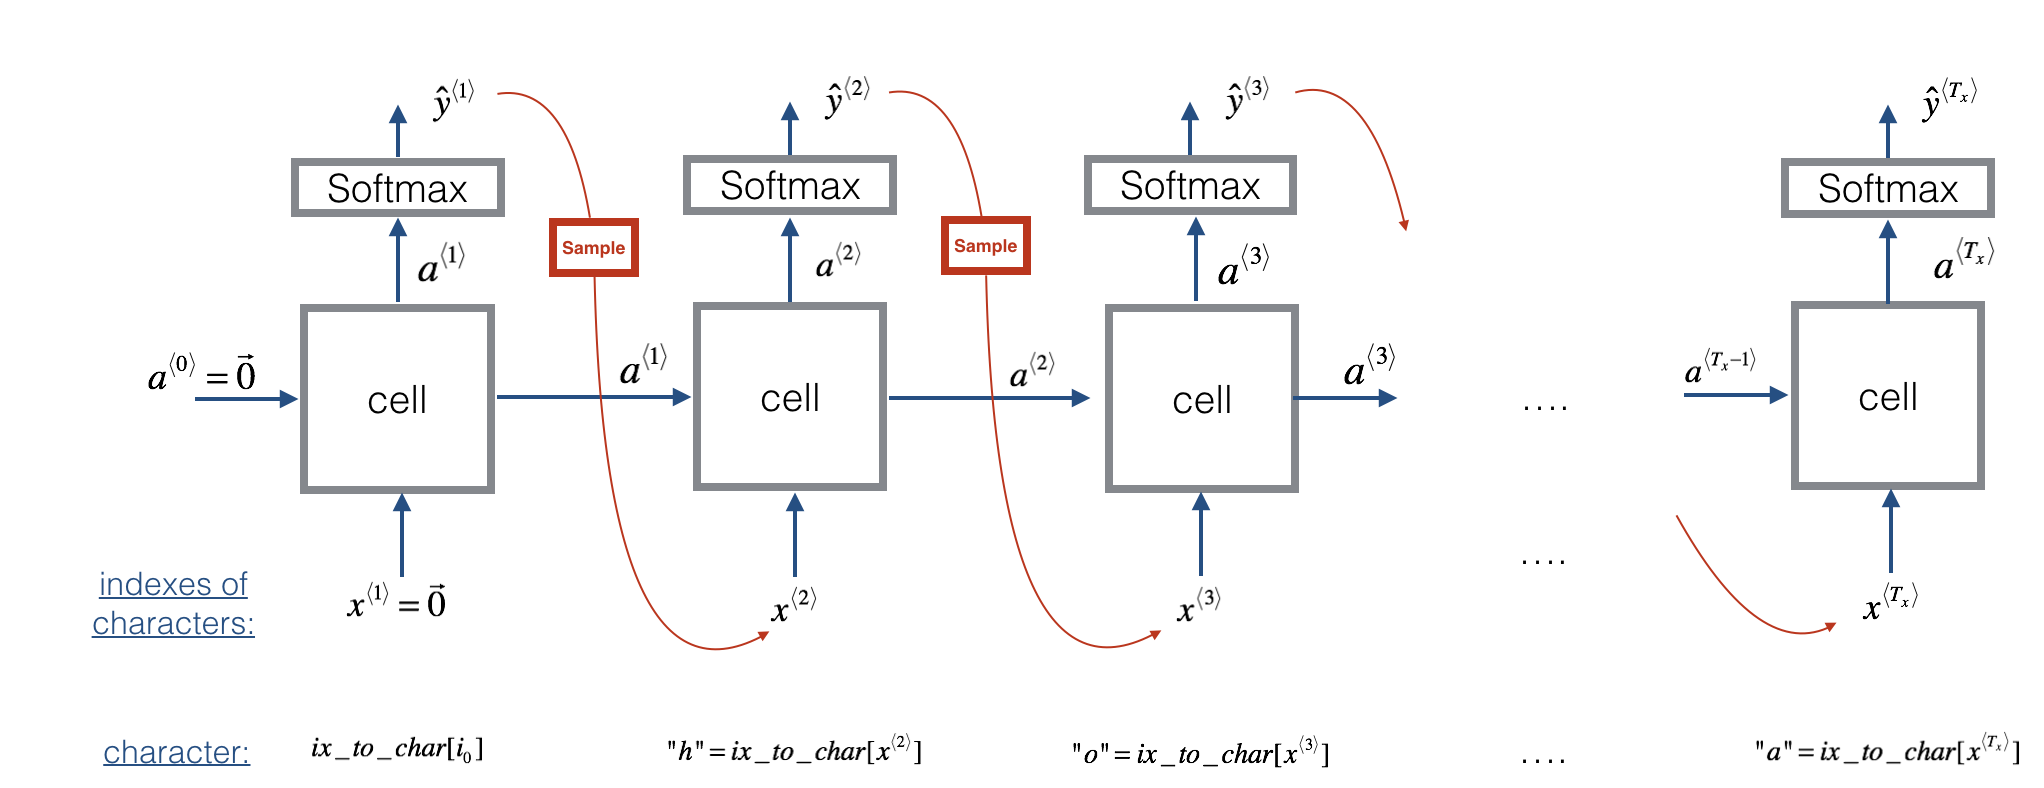

In [44]:
def sample(model):
    '''
    The model generates dinosaur name character by character
    '''
    model.eval()    # set model to evaluation mode
    word_size=0     # length of generated word

    # id конца строки
    newline_idx = trn_ds.ch_to_idx['>']
    # id начала строки
    start_char_idx = trn_ds.ch_to_idx['<']

    with torch.no_grad():   # disable gradient calculation because we don't need it for sampling during evaluation
        h_prev = torch.zeros([1, hidden_size], dtype=torch.float, device=device)    # initialize hidden state
        x = torch.zeros([1, trn_ds.vocab_size], dtype=torch.float, device=device)   # initialize input vector
        
        # инициализируем слово стартовым символом
        indices = [start_char_idx]
        x[0, start_char_idx] = 1    # set start_char_idx to 1
        predicted_char_idx = start_char_idx # set predicted_char_idx to start_char_idx
        

        # generate word until newline_idx or word_size == 50
        while predicted_char_idx != newline_idx and word_size != 50:
            
            h_prev, y_pred = model(h_prev, x) # forward pass
            # first run: h_prev - zero vector, x - start_char_idx
            # second run: h_prev - hidden state from first run, x - predicted_char_idx from first run
            
            y_softmax_scores = torch.softmax(y_pred, dim=1) # apply softmax to output so we get probabilities of each char
            for ind in indices:
              y_softmax_scores[0][ind] = 0  # set probability of already used characters to 0
            y_softmax_scores = y_softmax_scores / y_softmax_scores.sum()    # normalize probabilities to sum to 1
            
            # получаем следующий символ
            # Generates a random sample from a given 1-D array of probabilities y_softmax_scores with shape of vocab_size
            predicted_char_idx = np.random.choice(
                a=np.arange(trn_ds.vocab_size),            # вектор с индексами символов 0-28 (0, 1, 2, ..., vocab_size-1)
                # retrieve y_softmax_scores and move it to cpu, convert to numpy array and flatten it
                p=y_softmax_scores.cpu().numpy().ravel() # сэмплирование с учетом вероятностей
                )
            indices.append(predicted_char_idx)  # add predicted_char_idx to indices
            
            # initialize input vector for next iteration
            x = torch.zeros((1, trn_ds.vocab_size), dtype=torch.float, device=device)   # initialize zero input vector 
            x[0][predicted_char_idx] = 1    # set predicted_char_idx to 1 (one-hot encoding)
            
            word_size += 1
        
        if word_size == 50:
            indices.append(newline_idx)
    return indices

In [45]:
def check_uniqueness(name):
    '''Check if name is unique'''
    if name in names:
        return False
    else:
        return True

def print_sample(sample_idxs):
  '''Print sample'''
  name = ''.join(trn_ds.idx_to_ch[x] for x in sample_idxs)#.strip("<>")
  print(f'{name:<30} is unique -{check_uniqueness(name)}')
  # return name

print_sample(sample(model)) # generating sample before training gives us random characters

<kodrt>                        is unique -True


In [46]:
print_methods(trn_dl)

2 methods for <class 'torch.utils.data.dataloader.DataLoader'>: 
 ['check_worker_number_rationality', 'collate_fn']


['check_worker_number_rationality', 'collate_fn']

Обучим получившуюся модель

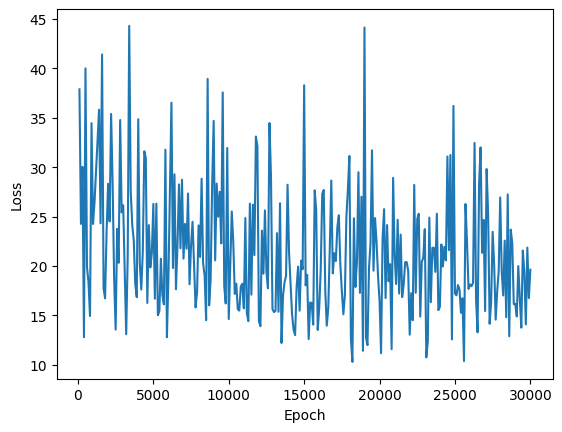

0

In [47]:
def train_one_epoch(model, loss_fn, optimizer):
    '''Train model for one epoch
    model - model to train
    loss_fn - loss function
    optimizer - optimizer
    '''

    model.train()
    for line_num, (x, y) in enumerate(trn_dl):
        # x - input tensor, shape: (batch_size, seq_len, vocab_size)
        # y - target tensor, shape: (batch_size, seq_len)
        # batch_size = 1, seq_len = len(x_str) = len(y_str)
        

        loss = 0
        optimizer.zero_grad()
        h_prev = torch.zeros([1, hidden_size], dtype=torch.float, device=device)
        x, y = x.to(device), y.to(device)

        for i in range(x.shape[1]):
            # Teacher forcing
            # optimizer.zero_grad()  
            # h_prev - hidden state from previous iteration
            # x[:, i] - input vector for current iteration (current char in sequence)
            h_prev, y_pred = model(h_prev, x[:, i])
            # y_pred - output vector for current iteration
            # y[:, i] - target vector for current iteration (next char in sequence)
            loss += loss_fn(y_pred, y[:, i])
        
            # loss.backward(retain_graph=True)
            # optimizer.step()
        loss.backward()
        optimizer.step()
            
        # if (line_num+1) % 100 == 0:
        #     print_sample(sample(model))        
        #     print(f'Loss: {loss.item():.3f}')        


        return loss

def train(model, loss_fn, optimizer,  epochs=1):
    '''Train model
    model - model to train
    loss_fn - loss function
    optimizer - optimizer
    epochs - number of epochs
    '''
    results = {}
    model.train()   # set model to training mode

    for e in range(1, epochs+1):

        loss = train_one_epoch(model, loss_fn, optimizer)
        if e % 100 == 0:
            # print_sample(sample(model))
            print(f'Epoch:{e} - loss: {loss:1.4f}', end = '\r')   
            results[e] = loss.item()
    return results


results = train(model, loss_fn, optimizer, epochs=30000)

# plot loss
import matplotlib.pyplot as plt
plt.plot(results.keys(), results.values())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


os.system(f'say "Training the {model.__class__.__name__} model finished"')

In [48]:
for i in range(10):
  print_sample(sample(model))

<kelopicryx>                   is unique -True
<quicophes>                    is unique -True
<loptarus>                     is unique -True
<jianodeltus>                  is unique -True
<lusomeratipyn>                is unique -True
<dapurvenithos>                is unique -True
<hustonicera>                  is unique -True
<antuspelodhmiv>               is unique -True
<bathyspenux>                  is unique -True
<anchodris>                    is unique -True


In [49]:
for i in range(10):
    print_sample(sample(model))

<catlods>                      is unique -True
<qaeltosiduh>                  is unique -True
<halturibezos>                 is unique -True
<teriahos>                     is unique -True
<bedong>                       is unique -True
<bythuropila>                  is unique -True
<longuya>                      is unique -True
<pictongea>                    is unique -True
<gacendris>                    is unique -True
<anisychodeg>                  is unique -True


### Упражнение 2.
Измените функцию `sample()` для генерации слов, в которых буквы не повторяются.

### Check uniqness of dinos names

In [50]:
for i in range(30000):
    name = ''.join(trn_ds.idx_to_ch[x] for x in sample(model))
    if not check_uniqueness(name):
        print(name)
        

<sinopelta>
<yulong>


In [51]:
'<yulong>' in names, '<ceratops>' in names

(True, True)

### Упражнение 3.
Измените функцию sampling с использованием temperature sampling (https://nlp.stanford.edu/blog/maximum-likelihood-decoding-with-rnns-the-good-the-bad-and-the-ugly/).

## Ссылки

1. Sampling in  RNN: https://nlp.stanford.edu/blog/maximum-likelihood-decoding-with-rnns-the-good-the-bad-and-the-ugly/
2. Coursera course (main source): https://github.com/furkanu/deeplearning.ai-pytorch/tree/master/5-%20Sequence%20Models
3. Coursera course (main source): https://github.com/Kulbear/deep-learning-coursera/blob/master/Sequence%20Models/Dinosaurus%20Island%20--%20Character%20level%20language%20model%20final%20-%20v3.ipynb
4. LSTM: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

# My model

In [52]:
# !pip install torchsummary
import torch
import torch.nn as nn
from torchsummary import summary
import numpy as np

### dataset

In [53]:
# Define your dinosaur names dataset
dino_names = [name.strip().lower() + '>' for name in open('data/dinos.txt').readlines()]

# define vocabulary and its size (number of unique characters) from dynos.txt
with open('data/dinos.txt') as f:
    content = f.read().lower()
    content = content.replace('\n', '')
    vocab = sorted(set(content)) + ['>']
    vocab_size = len(vocab)
print(vocab, vocab_size)


['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '>'] 27


### transformations

In [54]:
# Create a character-to-index and index-to-character mapping
char_to_idx = {char: idx for idx, char in enumerate(vocab)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

print(idx_to_char,'\n')
print(char_to_idx,'\n')

# Convert dino names to sequences of indices
name_sequences = [[char_to_idx[char] for char in name] for name in dino_names]
for el in zip(name_sequences[:3], dino_names[:3]):
    print(f'{el[1]:<50}: {el[0]}')


{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: '>'} 

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '>': 26} 

aachenosaurus>                                    : [0, 0, 2, 7, 4, 13, 14, 18, 0, 20, 17, 20, 18, 26]
aardonyx>                                         : [0, 0, 17, 3, 14, 13, 24, 23, 26]
abdallahsaurus>                                   : [0, 1, 3, 0, 11, 11, 0, 7, 18, 0, 20, 17, 20, 18, 26]


### dataloader

In [55]:
# Create a simple DataLoader (you can use more advanced techniques for batching)
def dataloader(sequences, batch_size)->torch.Tensor:
    '''Dataloader for sequences
    sequences - list of sequences
    batch_size - batch size
    '''
    for i in range(0, len(sequences), batch_size): # iterate over sequences with step=batch_size
        batch = sequences[i:i+batch_size]   # take batch_size sequences
        max_length = max(len(name) for name in batch)   # find max length of sequence in batch
        padded_batch = [name + [0] * (max_length - len(name)) for name in batch]    # pad all sequences in batch to max_length with zeros
        yield torch.tensor(padded_batch, dtype=torch.long)  # yield batch as tensor

### torch RNN model

In [56]:
class DinoRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(DinoRNN, self).__init__()
        self.hidden_size = hidden_size  # size of hidden state
        self.num_layers = num_layers   # number of layers in RNN

        self.embedding = nn.Embedding(input_size, hidden_size)  # embedding layer (one-hot encoding)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)   # RNN layer (hidden_size -> hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)   # fully connected layer (hidden_size -> output_size)
        self.dropout = nn.Dropout(0.3)  # dropout layer to prevent overfitting

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.dropout(out)  # Apply dropout to the RNN output
        out = self.fc(out)
        return out, hidden
    
# model parameters
input_size = len(char_to_idx)   # size of input vector
hidden_size = 64
output_size = len(char_to_idx)  # size of output vector
num_layers = 2

# Instantiate the DinoRNN model
model_my = DinoRNN(input_size, hidden_size, output_size, num_layers)


### training

In [57]:
# Training parameters
batch_size = 512
learning_rate = 0.001
num_epochs = 300
# window_size = 3

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()   
optimizer = torch.optim.Adam(model_my.parameters(), lr=learning_rate)

# Training loop
model_my.train()             # Set model to training mode
prev_loss = float('inf')  # Initialize with a large value
no_improvement_count = 0  # Counter for consecutive epochs without improvement (early stopping)
results = {}  # Dictionary for storing results

for epoch in range(num_epochs):
    for batch in dataloader(name_sequences, batch_size):
        optimizer.zero_grad() # This line clears the gradients of the model's parameters, preparing for a NEW batch's gradient calculations.
        
        # generate predictions (outputs) for the next characters in the sequences
        batch_till_last = batch[:, :-1] # slice batch to get all but last character in each sequence
        outputs, _ = model_my(batch_till_last, None) # slice batch to get all but last character in each sequence, None is for hidden state
        # The reason for excluding the last character is that you're using a sequence-to-sequence approach 
        # where you want the model to predict the next characters in the sequences.

        batch_from_1 = batch[:, 1:] # slice batch to get all but first character in each sequence
        transposed_outputs = outputs.transpose(1, 2)  # Transpose outputs to match dimensions of batch_from_1
        loss = criterion(transposed_outputs, batch_from_1) # Transpose to match dimensions
        loss.backward() # calculates the gradients of the model's parameters for the current batch


        optimizer.step()    #  updates the model's parameters using the computed gradients and the optimization algorithm (e.g., Adam or SGD).

        results[epoch] = loss.item()   # store loss for current epoch


    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}", end='\r')
    
    if loss >= prev_loss:
        no_improvement_count += 1
    else:
        no_improvement_count = 0
        prev_loss = loss
    
    if no_improvement_count >= 5:
        print(f"Loss hasn't improved for {no_improvement_count} epochs. Stopping training.")
        break

# Save the trained model
torch.save(model_my.state_dict(), "data/dino_rnn_model.pth")


os.system(f'say "Training the {model_my.__class__.__name__} model finished"')


Loss hasn't improved for 5 epochs. Stopping training.


0

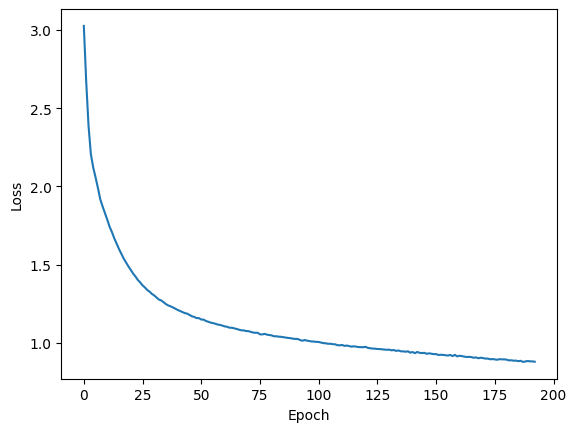

In [58]:
# plot loss
import matplotlib.pyplot as plt
plt.plot(results.keys(), results.values())  
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [59]:
import random
import numpy as np


def generate_dino_name(model_my, char_to_idx, idx_to_char, max_length, temperature=1.0, start_sequence=None):
    model_my.eval() # Set model to evaluation mode
    with torch.no_grad():   # disable gradient calculation because we don't need it for sampling during evaluation

        # FIRST CHARACTER

        # Randomly choose a starting character excluding '>'
        while True:
            start_char = random.choice(list(char_to_idx.keys()))
            if start_char != '>':
                generated_name = start_char
                break
            
        if start_sequence:
            generated_name = start_sequence
            

        input_char = torch.tensor([[char_to_idx[start_char]]], dtype=torch.long)    # Initialize input character as a tensor
        hidden = None # Initialize the hidden state as None for the first iteration
        

        # LOOP UNTIL MAX LENGTH IS REACHED

        while len(generated_name) < max_length:
            
            output, hidden = model_my(input_char, hidden)  # Forward pass, hidden state is initialized with the previous hidden state
            # output shape: [batch_size, sequence_length, num_classes] = [1, 1, vocab_size]

            predicted_probs = torch.softmax(output[0, -1, :] / temperature, dim=0)  # selects the predictions for the last character in the first sequence of the batch
            # Softmax with temperature:
            # When the temperature is close to 0, the softmax function produces a distribution that closely resembles the original logits.
            # When the temperature is high, the softmax function produces a more uniform distribution.

            # Use predicted_probs to sample characters based on their frequency distribution
            predicted_char_idx = torch.multinomial(predicted_probs, num_samples=1).item()
            predicted_char = idx_to_char[predicted_char_idx]
            
            if predicted_char == '>':  # Stop generating when '>' character is predicted
                # generated_name += predicted_char
                break
                
            generated_name += predicted_char
            input_char = torch.tensor([[predicted_char_idx]], dtype=torch.long)   # Initialize input character as a tensor for the next iteration

        return generated_name



In [60]:
model_my.eval()
temperature = .5
for _ in range(15): 
    generated_name = generate_dino_name(model_my, char_to_idx, idx_to_char, max_length=20, temperature=temperature, start_sequence='')
    print("", generated_name)

 stroceratops
 griodon
 ceratops
 quanosaurus
 eratops
 yuanosaurus
 garustanasaurus
 crosaurus
 pterosaurus
 eurtosaurus
 aratonosaurus
 zhingosaurus
 zuancosaurus
 eletorochirus
 ellong


In [61]:
cnt = 0
n_iterations = 1000
results = {}
for temp in np.arange(0.1, 1.1, 0.1):
    cnt = 0
    for i in range(n_iterations):
        name = generate_dino_name(model_my, char_to_idx, idx_to_char, max_length=25, temperature=temp, start_sequence='')
        if not check_uniqueness('<'+name+'>'):
            cnt += 1
    results[temp] = 100-cnt/n_iterations*100

import plotly.express as px
fig = px.line(x=list(results.keys()), y=list(results.values()), title='Temperature vs. Uniqueness', height=600)
fig.update_layout(xaxis_title='Temperature (creativity)', yaxis_title='Uniqueness, %')
fig.show()


In [62]:
for i in range(n_iterations):
    name = generate_dino_name(model_my, char_to_idx, idx_to_char, max_length=20, temperature=.8, start_sequence='')
    if not check_uniqueness('<'+name+'>'):
        print('\t',name) #, end='\r')
        cnt += 1
print(f'Uniqueness is {100-cnt/n_iterations*100:.2f}%')

	 anchisaurus
	 elosaurus
	 proceratosaurus
	 sinopelta
	 ceratops
	 sinosaurus
	 ceratops
	 titanosaurus
	 ceratops
	 sinosaurus
	 sinosaurus
Uniqueness is 98.60%


ToDo:
1. first char should be sampled from the distribution of the first char in the dataset
